In [3]:
import yfinance as yf
import numpy as np
#import random as rn
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import requests
#import datetime as dt
from scipy import stats
#from sklearn import linear_model

In [4]:
# GET ETF HISTORICAL DATA
etf = 'VOO'  #Vanguard S&P 500 ETF
period = '10y'
etf_data = yf.download(etf, period=period)['Adj Close']


[*********************100%***********************]  1 of 1 completed


In [5]:
# RETRIEVE LIST OF ASSETS FOR VOO
# https://stackoverflow.com/questions/38486477/get-html-table-into-pandas-dataframe-not-list-of-dataframe-objects

url = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies') 
web = pd.read_html(url.text)
assets = web[0]['Symbol'].tolist()
assets = sorted(assets)
# DELETE BRK.B AND BF.B BECAUSE THEY CONSTANTLY COME OUT AS DELISTED
assets.remove("BRK.B")
assets.remove("BF.B")

In [6]:
# RETRIEVE ASSET DATA

assets_data = yf.download(assets, period=period)
assets_price = pd.DataFrame(assets_data['Adj Close'])
assets_volume = pd.DataFrame(assets_data['Volume'])

[*********************100%***********************]  501 of 501 completed


In [7]:
# SLOPE 52 WEEK TREND
# https://stackoverflow.com/questions/49100471/how-to-get-slopes-of-data-in-pandas-dataframe-in-python

def polyfit(data):
    return(np.polyfit(list(range(1, 261)),data , 1)[0])

df_slope_52_week = pd.DataFrame(assets_price.rolling(window = 52*5).apply(polyfit))
df_slope_52_week = df_slope_52_week.dropna(how='all')

df_zscores_slope_52 = pd.DataFrame(stats.zscore(df_slope_52_week.transpose(), nan_policy='omit'))


In [8]:
# PERCENT ABOVE 260 DAY LOW
# https://www.investopedia.com/ask/answers/04/041604.asp#:~:text=The%20%22percentage%20off%20the%2052,or%20bottom%20of%20the%20range.

def percent_above_260_day(data):
    low = data.min()
    top = pd.Series(data).iloc[0]
    return ((top - low)/low * 100)

df_percent_above_260 = pd.DataFrame(assets_price.rolling(window=260).apply(percent_above_260_day))
df_percent_above_260 = df_percent_above_260.dropna(how='all')

df_zscores_percent_above_260 = pd.DataFrame(stats.zscore(df_percent_above_260.transpose(), nan_policy='omit'))


In [9]:
# 39 WEEK RETURN

def return_39_week(data):
    before = pd.Series(data).iloc[0]
    after = pd.Series(data).iloc[-1]
    return ((after - before)/before * 100)

df_return_39_week = pd.DataFrame(assets_price.rolling(window = 39*5).apply(return_39_week))
df_return_39_week = df_return_39_week.dropna(how='all')

df_zscores_return_39_week = pd.DataFrame(stats.zscore(df_return_39_week.transpose(), nan_policy='omit'))


In [10]:
# 51 WEEK PRICE VOLUME TREND 
# https://www.barchart.com/education/technical-indicators/price_volume_trend

rate = assets_price.pct_change(51*5)
volume_rate = assets_volume * rate
df_price_volume_trend = pd.DataFrame(assets_volume.shift(51*5) + volume_rate)
df_price_volume_trend = df_price_volume_trend.dropna(how='all')

df_zscores_pvt = pd.DataFrame(stats.zscore(df_price_volume_trend.transpose(), nan_policy='omit'))


In [11]:
# 4/52 WEEK PRICE OSCILLATOR
# https://www.statology.org/exponential-moving-average-pandas/
# https://www.investopedia.com/articles/investing/051214/use-percentage-price-oscillator-elegant-indicator-picking-stocks.asp#:~:text=Calculating%20the%20Percentage%20Price%20Oscillator,26%2Dday%20exponential%20moving%20average.

df_price_oscillator = pd.DataFrame((assets_price.ewm(span=4*5, adjust=False).mean() - assets_price.ewm(span=26*5, adjust=False).mean())/assets_price.ewm(span=26*5, adjust=False).mean())

df_zscores_oscillator = pd.DataFrame(stats.zscore(df_price_oscillator.transpose(), nan_policy='omit'))

In [12]:
# AGGREGATE Z SCORES
aggregate_zscores = (df_zscores_slope_52 + df_zscores_return_39_week + df_zscores_oscillator + df_zscores_percent_above_260 + df_zscores_pvt)/5
aggregate_zscores = aggregate_zscores.transpose()

In [13]:
# MONTHLY Z SCORES
df_monthly_zscore = pd.DataFrame(aggregate_zscores.resample('M').mean())

In [14]:
# LONG AND SHORT BUCKETS
num_stocks = 15
long_bucket = df_monthly_zscore.iloc[-1].nlargest(15)
short_bucket = df_monthly_zscore.iloc[-1].nsmallest(15)

In [15]:
# GET WEIGHTS
long_weights = long_bucket/long_bucket.sum()
short_weights = short_bucket/short_bucket.sum()
time = -5*12*4*5

In [16]:
# PORTFOLIO AND STOCK RETURNS
# https://campus.datacamp.com/courses/introduction-to-portfolio-risk-management-in-python/portfolio-investing?ex=1
stock_returns = assets_price[long_bucket.index.tolist() + short_bucket.index.tolist()][time: ].pct_change()
long_portfolio_returns = stock_returns.mul(long_weights, axis=1).sum(axis=1)
short_portfolio_returns = stock_returns.mul(short_weights, axis=1).sum(axis=1)

stock_returns['Long_Portfolio'] = long_portfolio_returns
stock_returns['Short_Portfolio'] = short_portfolio_returns
stock_returns['ETF'] = etf_data.pct_change()


In [17]:
# CUMULATIVE RETURNS
Cumulative_returns = ((1+stock_returns).cumprod()-1)
Cumulative_returns

,NVR,NVDA,META,AMD,AAPL,BKNG,RCL,AMZN,FSLR,AZO,...,ZION,TFC,CTLT,PNC,CFG,SBAC,CF,Long_Portfolio,Short_Portfolio,ETF
Date,,,,,,,,,,,,,,,,,,,,,
2018-08-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,-0.001259
2018-08-10,-0.012162,-0.006512,-0.015457,-0.002094,-0.002979,-0.023028,-0.004730,-0.006437,-0.030487,0.003626,...,-0.001693,-0.008789,-0.002486,-0.011500,-0.007884,-0.005415,-0.009648,-0.006289,-0.006550,-0.008047
2018-08-13,-0.033199,-0.001326,-0.016604,0.032984,0.003459,-0.045372,-0.004905,-0.001222,-0.036364,-0.009344,...,-0.010912,-0.013477,0.000994,-0.022793,-0.018478,-0.011150,-0.025929,-0.010134,-0.021160,-0.011784
2018-08-14,-0.022020,0.019379,-0.010814,0.048168,0.007687,-0.056034,0.019355,0.011130,-0.044812,0.025235,...,0.007902,0.012695,0.004475,-0.017215,-0.004681,-0.013699,-0.029165,0.000530,-0.014357,-0.005415
2018-08-15,-0.031465,0.010216,-0.019444,0.031414,0.010041,-0.040620,0.002540,-0.008375,-0.068871,0.021350,...,-0.002504,0.002539,0.004724,-0.022105,-0.020695,-0.012106,-0.047571,-0.004695,-0.024901,-0.012737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-10,1.116979,3.546239,0.273035,4.079581,2.472978,0.362198,-0.291997,0.160799,2.319376,2.712735,...,-0.487804,-0.355816,-0.164843,-0.078500,-0.233912,0.555173,0.538343,1.895424,0.573613,0.571250
2023-05-11,1.117457,3.497919,0.287837,4.083769,2.476780,0.367686,-0.299429,0.181763,2.364371,2.687677,...,-0.510880,-0.368756,-0.149925,-0.088768,-0.252008,0.528931,0.524500,1.903612,0.552758,0.569054
2023-05-12,1.111864,3.460460,0.277022,3.987435,2.457944,0.354424,-0.310807,0.161536,3.255096,2.706502,...,-0.516271,-0.357698,-0.182994,-0.097824,-0.252008,0.552942,0.518793,1.918361,0.550247,0.566941


<AxesSubplot: xlabel='Date'>

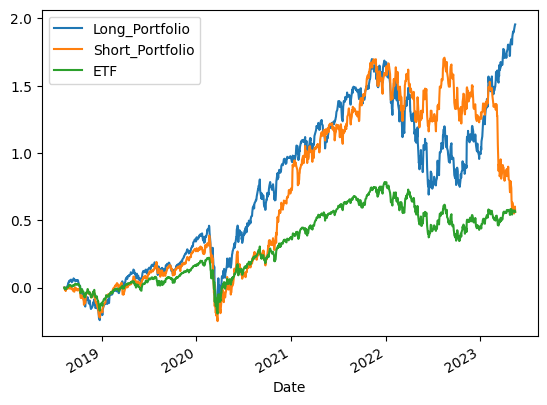

In [18]:
# CUMULATIVE PORTFOLIO RETURN VS ETF
Cumulative_returns[["Long_Portfolio", "Short_Portfolio", "ETF"]].plot()

<AxesSubplot: xlabel='Date'>

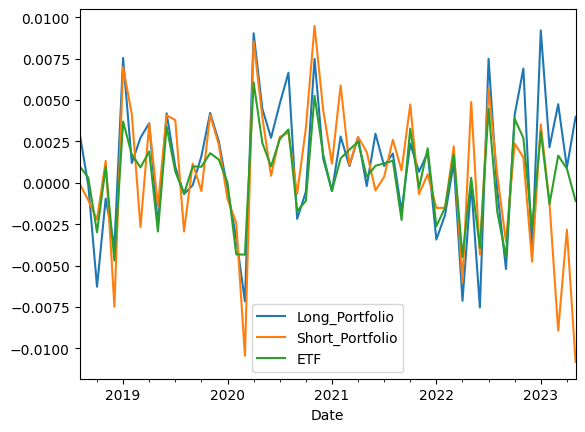

In [19]:
# MONTHLY RETURN LONG PICKS VS SHORT PICKS VS ETF
(stock_returns.resample('M').mean())[["Long_Portfolio", "Short_Portfolio", "ETF"]].plot()

In [28]:
# MONTHLY RETURNS BAR CHART
monthly_returns = stock_returns.resample('M').mean()
monthly_portfolio_returns = monthly_returns[['Long_Portfolio', 'Short_Portfolio', 'ETF']]


In [34]:
monthly_portfolio_returns['Long_Positive'] = (monthly_portfolio_returns['Long_Portfolio'] - monthly_portfolio_returns['ETF']) > 0
monthly_portfolio_returns['Short_Positive'] = (monthly_portfolio_returns['Short_Portfolio'] - monthly_portfolio_returns['ETF']) > 0
monthly_portfolio_returns['ETF_Positive'] = monthly_portfolio_returns['ETF'] > 0

monthly_portfolio_returns

/var/folders/34/c1d679mn5lx27q8b4g5wrcb40000gn/T/ipykernel_11556/3362775370.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_portfolio_returns['Long_Positive'] = (monthly_portfolio_returns['Long_Portfolio'] - monthly_portfolio_returns['ETF']) > 0
/var/folders/34/c1d679mn5lx27q8b4g5wrcb40000gn/T/ipykernel_11556/3362775370.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_portfolio_returns['Short_Positive'] = (monthly_portfolio_returns['Short_Portfolio'] - monthly_portfolio_returns['ETF']

,Long_Portfolio,Short_Portfolio,ETF,Long_Positive,Short_Positive,ETF_Positive
Date,,,,,,
2018-08-31,0.002994,-0.000046,0.001010,True,False,True
2018-09-30,-0.000140,-0.001053,0.000308,False,False,True
2018-10-31,-0.006276,-0.002220,-0.002983,False,True,False
2018-11-30,-0.000954,0.001329,0.000956,False,True,True
2018-12-31,-0.003871,-0.007484,-0.004696,True,False,False
2019-01-31,0.007540,0.006998,0.003698,True,True,True
2019-02-28,0.001196,0.004133,0.001697,False,True,True
2019-03-31,0.002726,-0.002672,0.000935,True,False,True
2019-04-30,0.003603,0.003570,0.001892,True,True,True


<AxesSubplot: ylabel='Date'>

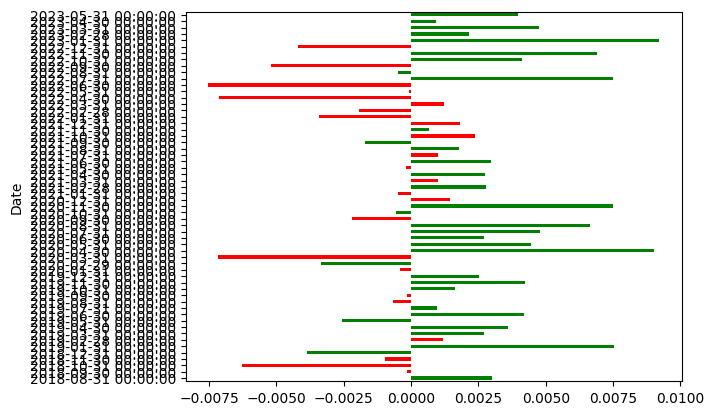

In [35]:
# LONG PORTFOLIO VS ETF
# POSITIVE (GREEN) = LONG RETURN BETTER THAN ETF RETURN
monthly_portfolio_returns['Long_Portfolio'].plot(
    kind='barh', color = monthly_portfolio_returns.Long_Positive.map({
        True: 'g', False: 'r'
    })
)

<AxesSubplot: ylabel='Date'>

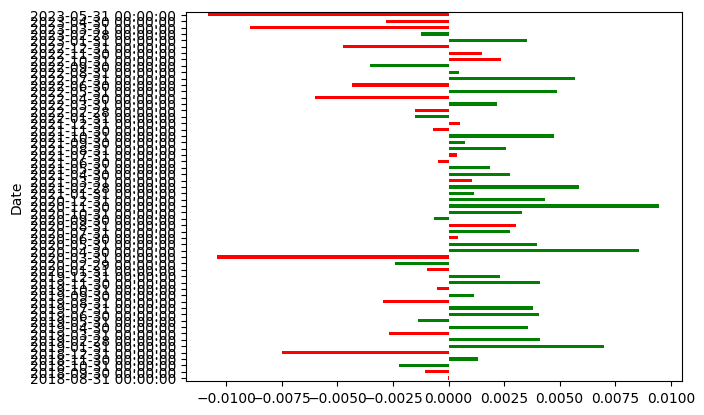

In [36]:
# SHORT PORTFOLIO VS ETF
# POSITIVE (GREEN) = SHORT RETURN BETTER THAN ETF RETURN
monthly_portfolio_returns['Short_Portfolio'].plot(
    kind='barh', color = monthly_portfolio_returns.Short_Positive.map({
        True: 'g', False: 'r'
    })
)

<AxesSubplot: ylabel='Date'>

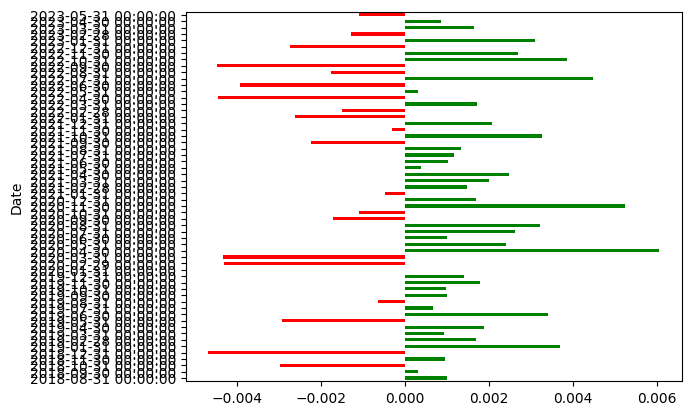

In [37]:
# ETF

monthly_portfolio_returns['ETF'].plot(
    kind='barh', color = monthly_portfolio_returns.ETF_Positive.map({
        True: 'g', False: 'r'
    })
)